# Bank Marketing

We have two datasets, one with 17 features and other with 21 features. The additional features are not user level features - social and economic context features.

In [1]:
%%bash
# run this cell only if packages need to be installed fresh. One time run
cat << EOF > requirements.txt
numpy
pandas
seaborn==0.11.1
matplotlib
scipy
ipywidgets
sklearn
imblearn
EOF

In [2]:
%%capture
%%bash
# run once to install the packages if already not available
pip install -r requirements.txt

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, percentileofscore
from ipywidgets import interactive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, precision_recall_fscore_support, precision_score, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, ADASYN
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [4]:
# pd.set_option('display.max_rows', None)

In [5]:
df = pd.read_csv("./bank/bank-full.csv", sep=";", header='infer')
full_df = pd.read_csv("./bank-additional/bank-additional-full.csv", sep=";", header="infer")

In [6]:
# used for ordering the months in the visualizations below
month_name_to_number = {'jan': 1, 
                        'feb': 2, 
                        'mar': 3, 
                        'apr': 4, 
                        'may': 5, 
                        'jun': 6, 
                        'jul': 7, 
                        'aug': 8, 
                        'sep': 9, 
                        'oct': 10, 
                        'nov': 11, 
                        'dec': 12}

In [7]:
full_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

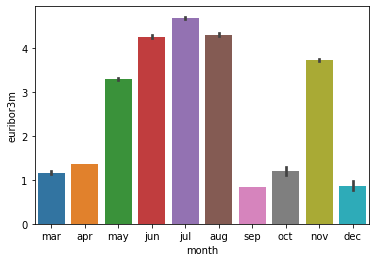

In [8]:
full_df['month_num'] = full_df['month'].map(month_name_to_number)
full_df = full_df.sort_values(['month_num']).reset_index(drop=True)
sns.barplot(x='month', y='euribor3m', data=full_df);

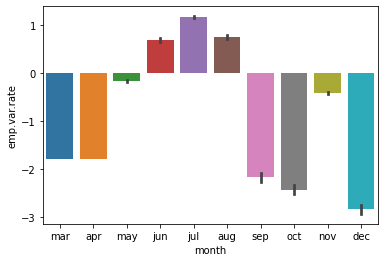

In [9]:
sns.barplot(x='month', y='emp.var.rate', data=full_df);

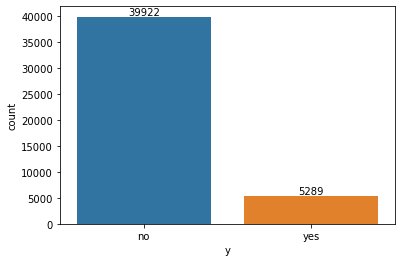

In [10]:
plot = sns.countplot(x='y', data=df);
for bar in plot.patches:
    plot.annotate(bar.get_height(), (bar.get_x() + bar.get_width()/2, bar.get_height()), va='bottom', ha='center')

In [11]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [12]:
list(map(len, [full_df, df, full_df.columns, df.columns]))

[41188, 45211, 22, 17]

In [13]:
set(full_df.columns).difference(set(df.columns))

{'cons.conf.idx',
 'cons.price.idx',
 'day_of_week',
 'emp.var.rate',
 'euribor3m',
 'month_num',
 'nr.employed'}

In [14]:
set(df.columns).difference(set(full_df.columns))

{'balance', 'day'}

No account balance in the dataframe with additional features (socio-economic features) which I believe might be an important feature. We will check the relationship between balance and the output variable below.

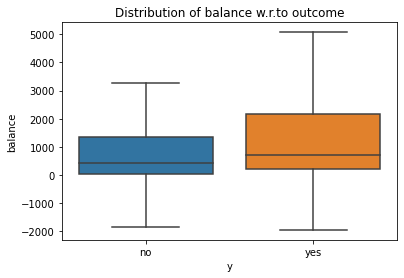

In [15]:
plot = sns.boxplot(x='y', y='balance', data=df, showfliers=False);
plt.title("Distribution of balance w.r.to outcome");

In [16]:
df['balance'].describe(percentiles=[0.1, 0.25, 0.50, 0.75, 0.90])

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
10%           0.000000
25%          72.000000
50%         448.000000
75%        1428.000000
90%        3574.000000
max      102127.000000
Name: balance, dtype: float64

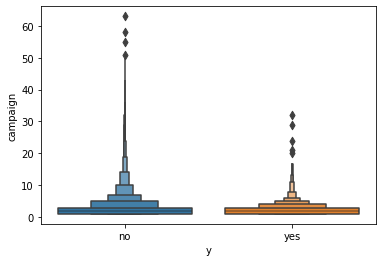

In [17]:
sns.boxenplot(x='y', y='campaign', data=df);

In [18]:
df['previous'].describe(percentiles=[0.25, 0.75, 0.9, 0.95, 0.99])

count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          2.000000
95%          3.000000
99%          8.900000
max        275.000000
Name: previous, dtype: float64

As we can see from the above distribution statistics, balance is heavily skewed. Mean is higher than medium and more than 90% of our customers have balance less than 3574. But the maximum balance is at 102k.

Based on the documentation from the dataset, we could see that the column `duration` is not going to be available to use during prediction. Our goal is to predict if a user will subscribe to term deposit before making a call. By using duration (assuming that shorter calls are negative outcomes and longer calls are positive outcomes), this feature will influence our prediction very much. 

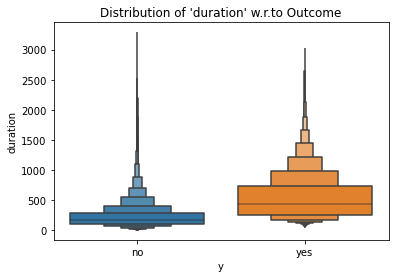

In [19]:
plot = sns.boxenplot(x='y', y='duration', data=df, showfliers=False);
plt.title("Distribution of 'duration' w.r.to Outcome");

Duration is a clear differentiator to identify if a user has converted or not, and it is a way to cheat in our prediction problem to use this feature as this feature value will not be available to use during the prediction time.

We have two numeric features in this dataset related to user features: Age and Balance. Let us see if these two features are correlated.

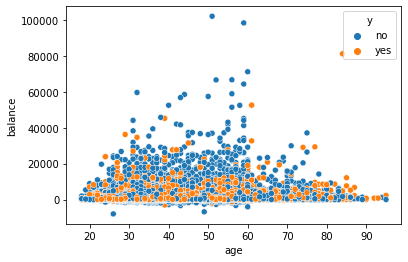

In [20]:
sns.scatterplot(x='age', y='balance', hue='y', data=df);

In [21]:
corr, _ = pearsonr(df['age'], df['balance'])
print(corr)

0.09778273937134746


Both the correlation co-efficient and the number tell us that age and balance are uncorrelated features. They should be good to be as features in training our model. 

We can also see how age relates to our label.

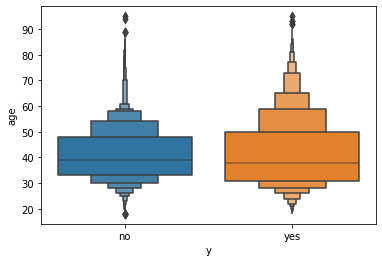

In [22]:
sns.boxenplot(x='y', y='age', data=df);

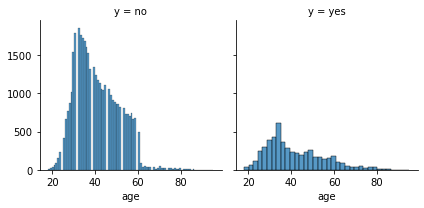

In [23]:
grid = sns.FacetGrid(data=df, col='y')
grid.map(sns.histplot, "age");

Not much difference in the age distribution with respect to the label except for the few outliers in the customers who subscribed for the term deposit. We will use the feature in our prediction model since this will be easy to obtain.

Now to deal with the categorical features, we have few approaches. But first, let us see how their relationship is with our target variable.

In [24]:
cat_vars = ['day', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [25]:
df['day'] = df['day'].astype('object')

In [26]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day          object
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [27]:
def plot_category_to_label_rel(cat_var_name):
    x = df[[cat_var_name, 'y']].groupby([cat_var_name, 'y']).size().unstack().reset_index()
    x['percent_y'] = x['yes']*100 / (x['yes'] + x['no'])
    x['total'] = x['yes'] + x['no']
#     x['percent_y'] = [format(l, '.2f') for l in x['percent_y']]
    
    if cat_var_name == 'month':
        x['month_num'] = x['month'].map(month_name_to_number)
        x = x.sort_values(['month_num']).reset_index(drop=True)

    
#     grid = sns.FacetGrid(data=local_df, col='y', height=4, aspect=2)
#     grid.map(sns.countplot, cat_var_name);
#     for ax in grid.axes.flat:
#         for label in ax.get_xticklabels():
#             label.set_rotation(90)

    # stacked barplot
    plt.figure(figsize=(15, 8))
    bar1 = sns.barplot(x=cat_var_name, y='total', color='red', data=x)
    bar2 = sns.barplot(x=cat_var_name, y='yes', color='lightgreen', data=x)
    
    plt.figure(figsize=(15,8))
    plot = sns.barplot(x=cat_var_name, y='percent_y', data=x, color='orange');
    plt.xticks(rotation=45, ha='right');
    plt.title(f'Percentage of customers converted per each {cat_var_name}');
    
    
interactive_plot = interactive(plot_category_to_label_rel, cat_var_name=cat_vars)
interactive_plot

interactive(children=(Dropdown(description='cat_var_name', options=('day', 'job', 'marital', 'education', 'def…

In [28]:
# Data pre-processing
try:
    df = df.drop(columns='duration')
except KeyError:
    print("Duration is already removed from the dataframe")

In [29]:
# converting categorical to one-hot encodings
df = pd.get_dummies(df, columns=cat_vars)

df.head()

,age,balance,campaign,pdays,previous,y,day_1,day_2,day_3,day_4,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33,1,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [30]:
# scaling the numerical values using MinMaxScaler
# mm_scaler = MinMaxScaler()
# std_scaler = StandardScaler()
# y = df['y']
# X = df.drop(columns='y')
# # mm_scaler.fit(X)
# # df = mm_scaler.transform(X)
# std_scaler.fit(X)
# df = std_scaler.transform(X)
# df = pd.DataFrame(df, columns=list(X.columns))
# df['y'] = y

In [31]:
df

,age,balance,campaign,pdays,previous,y,day_1,day_2,day_3,day_4,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33,1,1,-1,0,no,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,3,-1,0,yes,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45207,71,1729,2,-1,0,yes,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
45208,72,5715,5,184,3,yes,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
45209,57,668,4,-1,0,no,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [32]:
# model initialization
lr_base = LogisticRegression(max_iter=1000)
lr_weighted = LogisticRegression(max_iter=1000, class_weight={'yes': 1.5, 'no':1})
gbc = GradientBoostingClassifier()
gbc_sqrt = GradientBoostingClassifier(max_features='sqrt')

In [33]:
def plot_model_metrics(fitted_model, X_test, y_test):
    plot_confusion_matrix(fitted_model, X_test, y_test)
    plot_precision_recall_curve(fitted_model, X_test, y_test)

In [34]:
def split_train_test(df, sampling_technique=None):
    y = df['y']
    X = df.drop(columns='y')
    
    if sampling_technique == 'undersampling':
        undersampler = RandomUnderSampler()
        X, y = undersampler.fit_resample(X, y)
    elif sampling_technique == 'oversampling':
        oversampler = RandomOverSampler()
        X, y = oversampler.fit_resample(X, y)
    elif sampling_technique == 'adasyn':
        adasyn_sampler = ADASYN()
        X, y = adasyn_sampler.fit_resample(X, y)
    elif sampling_technique is None:
        pass
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    return X_train, X_test, y_train, y_test

In [35]:
X_train, X_test, y_train, y_test = split_train_test(df, 'adasyn')
y_test.value_counts()

yes    8034
no     7984
Name: y, dtype: int64

In [36]:
# lr_base.fit(X_train, y_train);
# lr_weighted.fit(X_train, y_train);
gbc.fit(X_train, y_train);
# gbc_sqrt.fit(X_train, y_train);

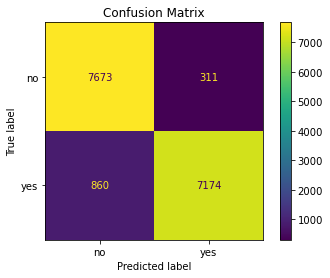

In [37]:
plot_confusion_matrix(gbc, X_test, y_test);
plt.title("Confusion Matrix");

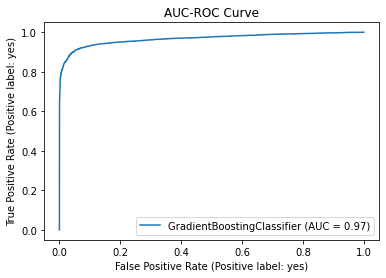

In [38]:
plot_roc_curve(gbc, X_test, y_test);
plt.title('AUC-ROC Curve');

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
scores = cross_val_score(gbc, X_test, y_test, cv=10)
np.mean(scores), np.std(scores)

(0.9264583776837354, 0.006761807786814854)

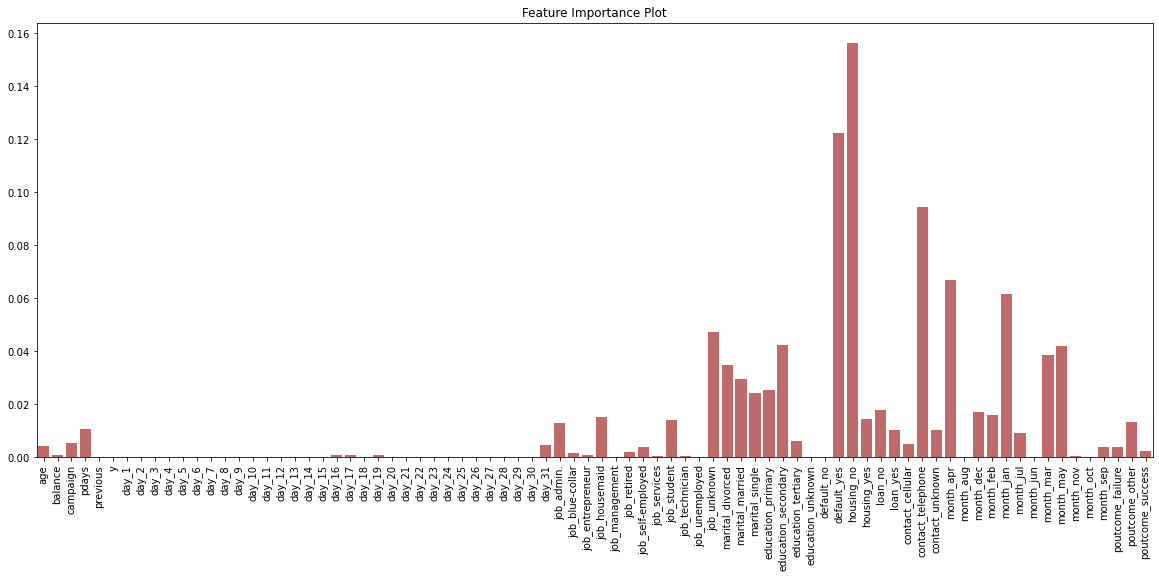

In [41]:
col_names = list(df.columns)[:-1]
feat_imp = gbc.feature_importances_
plt.figure(figsize=(20, 8))
plot = sns.barplot(x=col_names, y=feat_imp, color='indianred');
plt.xticks(rotation=90);
plt.title("Feature Importance Plot");

In [42]:
# y_pred_lr = lr_base.predict(X_test)
# y_pred_lr_weighted = lr_weighted.predict(X_test)
y_pred_gbc = gbc.predict(X_test)

In [43]:
y_test.value_counts()

yes    8034
no     7984
Name: y, dtype: int64

In [45]:
precision_recall_fscore_support(y_test, y_pred_gbc)

(array([0.89921481, 0.95845023]),
 array([0.96104709, 0.89295494]),
 array([0.92910335, 0.92454411]),
 array([7984, 8034]))